# Lotka-Volterra Simulations

This notebook contains inference results for the Lotka-Volterra model using simulated data. 

Using both the bootstrap and MVN filters, we plot the posteriors for each parameter with the following resolution numbers in high and low noise settings: 

- n_res = 1
- n_res = 2
- n_res = 8
- n_res = 16

### Notes

- The full Fisher information matrix isn't always reliable, it depends on the approximation of the log-likelihood. Sometimes for a very small number of particles we can get the full Fisher information matrix, sometimes for a large number of particles the FI matrix isn't positive definite.  This is for resolution size of 1 and low noise. 
- It seems like the MVN filter works better for the high noise setting and the bootstrap filter works better for the low noise setting?

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

import pfjax as pf
from pfjax.particle_filter import particle_filter, particle_loglik, particle_resample_mvn
from pfjax import proj_data, LotVolModel
import pfjax.sde
from pfjax import stoch_opt, get_sum_lweights#, get_sum_lweights_mvn

import warnings
warnings.filterwarnings('ignore')

In [11]:
import optax
from jax import random
from jax import lax
from jax.experimental.maps import xmap
from functools import partial
from pfjax import particle_loglik, particle_filter, particle_resample_mvn
from pfjax.stoch_opt import *
from pfjax import particle_resample_mvn

# def get_sum_lweights_mvn(theta, key, n_particles, y_meas, model):
#     """
#     Args:
#         theta: A `jnp.array` that represents the values of the parameters.
#         key: The key required for the prng.
#         n_particles: The number of particles to use in the particle filter.
#         y_meas: The measurements of the observations required for the particle filter.

#     Returns:
#         The sum of the particle log weights from the particle filters.
#     """
#     # model, key, y_meas, theta, n_particles,particle_sampler=particle_resample):
#     ret = particle_filter(model = model, y_meas = y_meas, theta = theta, n_particles = n_particles,
#                           key = key, particle_sampler=particle_resample_mvn)
#     sum_particle_lweights = particle_loglik(ret['logw'])
#     return -sum_particle_lweights

def get_sum_lweights(theta, key, n_particles, y_meas, model, **kwargs):
    """

    Args:
        theta: A `jnp.array` that represents the values of the parameters.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.
        particle_sampler: particle_resample_mvn for MVN approximation. None for bootstrap filter

    Returns:
        The sum of the particle log weights from the particle filters.
    """
    ret = particle_filter(model, key, y_meas, theta, n_particles, **kwargs)
    sum_particle_lweights = particle_loglik(ret['logw'])
    return -sum_particle_lweights

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None, **kwargs):
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model, **kwargs)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates)


def grad_desc(model, params, grad_fun, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None, eps=1e-5, hessian=False,
              **kwargs):
    """
    Deterministic optimization 
    
    Args:
        model: The model class for which all of the functions are defined.
        params: A jnp.array that represents the initial values of the parameters.
        grad_fun: Negative log-likelihood
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
        eps: Threshold for update size. If we have more than 10 consecutive updates less than eps algorithm will stop 
    Returns: 
        Parameters at argmin(grad_fun) and Hessian of the negative log-likelihood
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer, **kwargs)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    if hessian:
        hessian_fn = jax.jacfwd(jax.jacrev(grad_fun))
    else :
        hess = None
    n_thresh = 10 # number of consecutive times parameter updates can be less than eps
    key, subkey = random.split(key) # one key for deterministic optimization 
    for i in range(iterations):
        print("iteration: ", i)
        new_params = update_fn(params, subkey, opt_state)
        print(new_params)
        if hessian:
            hess = hessian_fn(
                new_params,
                subkey,
                n_particles=n_particles,
                y_meas=y_meas,
                model=model)
            if jnp.all(jnp.linalg.eigvals(hess) >= 0): 
                break 
        diff = jnp.linalg.norm(params - new_params)
        print("Diff: ", diff)
        if diff < eps :
            if n_thresh <= 1:
                params = new_params
                break
            else :
                n_thresh -= 1
        else :
            n_thresh = 10
        params = new_params
    return params, hess

In [5]:
@jax.jit
def lotvol_pf_mvn_loglik(theta, y_meas):
    temp = particle_filter(theta=theta, model=lotvol_model, 
                           y_meas=y_meas, 
                           n_particles=n_particles, key=key,
                           particle_sampler = particle_resample_mvn)
    return particle_loglik(temp['logw'])


@jax.jit
def lotvol_pf_loglik(theta, y_meas):
    temp = particle_filter(theta=theta, 
                           model=lotvol_model, y_meas=y_meas,
                           n_particles=n_particles, key=key)
    return particle_loglik(temp['logw'])


def loglik_hessian (key, loglik, model, params, y_meas, n_particles):
    """ Evaluate the hessian of a given log-likelihood """
    hessian = jax.jacfwd(jax.jacrev(loglik))
    hess = hessian(params,
                   key, 
                   n_particles=n_particles, 
                   y_meas=y_meas, 
                   model=model)
    return hess

def masked_loglik(theta1, theta2, key, n_particles, y_meas, model, rev = False, **kwargs):
    """ 
    Take 2nd derivative of log-likelihood w.r.t theta1 and fix theta2 (need to be contiguous)
    Args: 
        particle_sampler = particle_resample_mvn for the MVN filter
    """
    if rev: 
        theta = jnp.concatenate([theta2, theta1])
    else :
        theta = jnp.concatenate([theta1, theta2])
    ret = particle_filter(model = model, y_meas = y_meas, theta = theta, n_particles = n_particles,
                          key = key, **kwargs)
    sum_particle_lweights = particle_loglik(ret['logw'])
    return sum_particle_lweights


def inference (key, loglik, y_meas, model, init_params, n_particles = 250, lr = 1e-6, n_iter=100, 
               hessian = False, **kwargs):
    """ Run stochastic optimization and return Hessian evaluated at mode """
    params, hess = grad_desc(
        model = model, 
        params = init_params, 
        grad_fun = loglik, 
        y_meas = y_meas, 
        key=key, 
        n_particles = n_particles,
        learning_rate=lr, 
        iterations=n_iter,
        mask=np.array([1,1,1,1,1,1,1,1]),
        hessian = hessian,
        **kwargs)
#     neg_hess = loglik_hessian(
#         key = key,
#         loglik = loglik,
#         params = params,
#         model = model,
#         y_meas = y_meas,
#         n_particles = 1_000)
    if hessian:
        var_hat = jnp.linalg.inv(hess) 
        print("Postitive def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))
    else:
        var_hat = None
    return params, hess, var_hat

# Low Noise Setting


In [6]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1 
tau_l = 0.1 

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/5), theta + (theta/5))))

dt = 0.1
n_res = 1 # 1, 2, 4, 8, 16
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)
y_meas_abs = jnp.abs(y_meas)

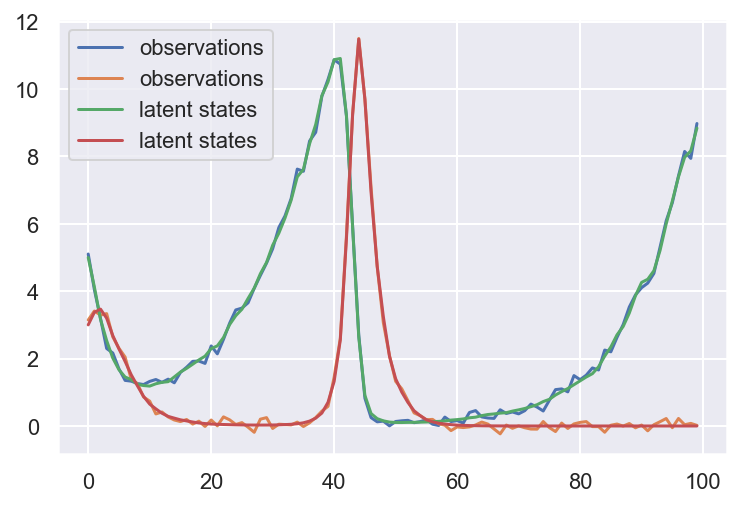

In [7]:
plt.plot(y_meas, label = "observations");
# plt.plot(x_state.reshape(n_obs, n_res*2), label = "latent states")
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

## Log-Likelihood Plots

In [ ]:
n_particles = 250

plot_mvn = proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x, y_meas_abs), 
                    theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

plot_bootstrap = proj_data(fun = lambda x: lotvol_pf_loglik(x, y_meas_abs),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_bootstrap["method"] = "bootstrap"
df = pd.concat([plot_bootstrap, plot_mvn])

sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

In [ ]:
# params:
lr_res1 = 1e-5
n_particles = 100
n_iter = 100

### MVN Approximation

iteration:  0
[0.9999 1.0001 3.9999 1.0001 0.1001 0.0999 0.1001 0.1001]
Postitive def:  True


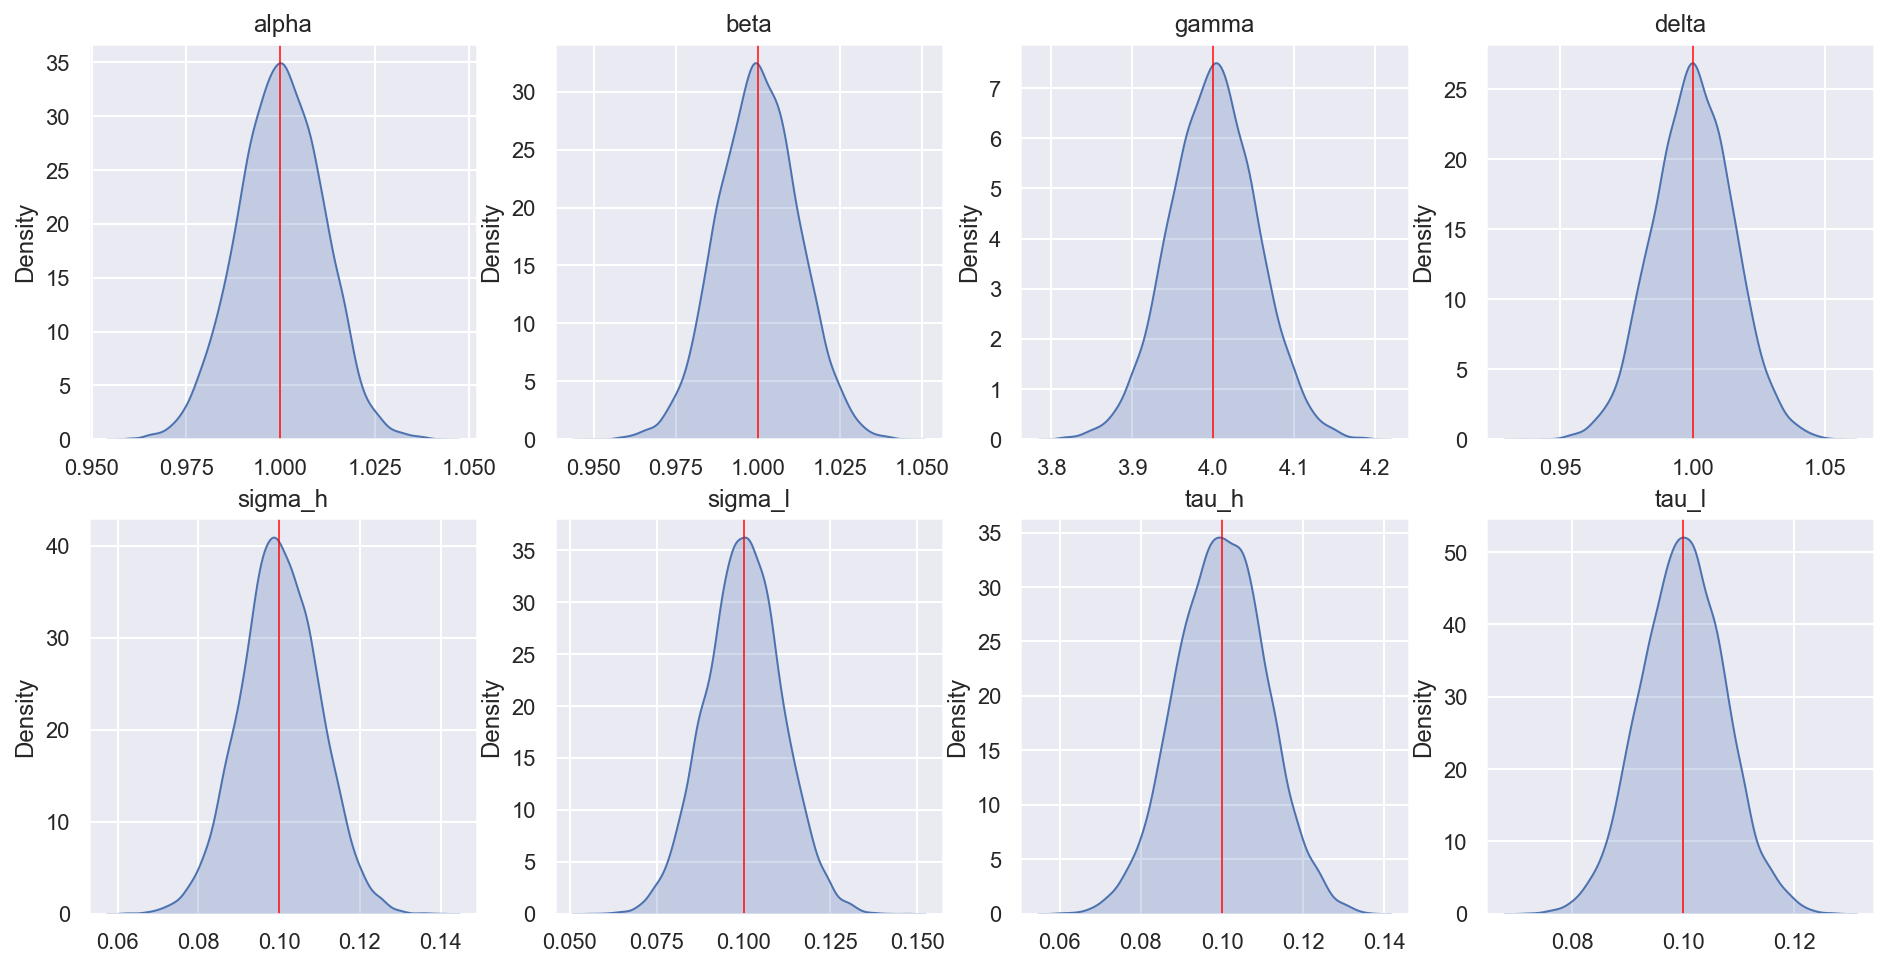

In [13]:
mvn_params, mvn_hess, mvn_var = inference(
    key = key,
    loglik = get_sum_lweights,
    y_meas = y_meas,
    lr = 1e-4,
    model = lotvol_model,
    n_iter = 150,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]),
    hessian = False,
    eps = 1e-6,
    particle_sampler = particle_resample_mvn
)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=mvn_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 6
hess = hessian(mvn_params[:i], mvn_params[i:],
               key, 
               n_particles=5000, 
               y_meas=y_meas, 
               particle_sampler = particle_resample_mvn,
               model=lotvol_model)
var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=mvn_params[:i], cov=var_hat, shape=(1_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
np.diag(hess)

### Bootstrap PF

In [ ]:
def get_sum_lweights(theta, key, n_particles, y_meas, model, **kwargs):
    """

    Args:
        theta: A `jnp.array` that represents the values of the parameters.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.

    Returns:
        The sum of the particle log weights from the particle filters.
    """
    ret = particle_filter(model, key, y_meas, theta, n_particles)
    sum_particle_lweights = particle_loglik(ret['logw'])
    return sum_particle_lweights

In [ ]:
bs_params, bs_hess, bs_var = inference(
    key = key,
    loglik = get_sum_lweights,
    y_meas = y_meas,
    model = lotvol_model,
    n_iter = 10,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2])
)

mle_samples = random.multivariate_normal(key=key, mean=bs_params, cov=bs_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
bs_hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 4
hess = bs_hessian(
    bs_params[:i], bs_params[i:],
    key, 
    n_particles=5000, # doesnt work with 1000 particles... ??
    y_meas=y_meas, 
    model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=bs_params[:i], cov=var_hat, shape=(1_000, ))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
del(y_meas, x_state)

# High Noise

In [ ]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/5), theta + (theta/5))))

dt = 0.1
n_res = 1 # 1, 2, 4, 8, 16
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_hi, x_state_hi = pf.simulate(model = lotvol_model, 
                                    n_obs = n_obs, 
                                    x_init = x_init, 
                                    theta = theta, 
                                    key = subkey)
y_meas_hi_abs = jnp.abs(y_meas_hi)

In [ ]:
plt.plot(y_meas_hi, label = "observations");
plt.plot(y_meas_hi_abs, label = "observations (abs)");
plt.plot(jnp.exp(x_state_hi.squeeze()), label = "latent states")
plt.legend();

In [ ]:
n_particles = 250
plot_mvn = proj_data(fun = lambda x: lotvol_pf_mvn_loglik(x, y_meas_hi), 
                    theta = theta, theta_lims = theta_lims, 
                    theta_names = theta_names)

plot_bootstrap = proj_data(fun = lambda x: lotvol_pf_loglik(x, y_meas_hi),
                           theta = theta, 
                           theta_lims = theta_lims, 
                           theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_bootstrap["method"] = "bootstrap"
df = pd.concat([plot_bootstrap, plot_mvn])

sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood Projection Plots");

### MVN Filter

In [ ]:
mvn_params, mvn_hess, mvn_var = inference(
    key = key,
    loglik = get_sum_lweights_mvn,
    y_meas = y_meas_hi,
    model = lotvol_model,
    lr = 1e-2,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2])
)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=mvn_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 6
hess = hessian(mvn_params[:i], mvn_params[i:],
               key, 
               n_particles=5000, # doesnt work with 1000 particles... ??
               y_meas=y_meas_hi, 
               particle_sampler = particle_resample_mvn,
               model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=mvn_params[:i], cov=var_hat, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

### Bootstrap Filter

In [ ]:
bs_params, bs_hess, bs_var = inference(
    key = key,
    loglik = get_sum_lweights,
    y_meas = y_meas_hi,
    n_iter = 25,
    model = lotvol_model,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2])
)

mle_samples = random.multivariate_normal(key=key, mean=bs_params, cov=bs_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 6
hess = hessian(mvn_params[:i], mvn_params[i:],
               key, 
               n_particles=5000, 
               y_meas=y_meas_hi, 
               model=lotvol_model)
var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=bs_params[:i], cov=var_hat, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

In [ ]:
del(y_meas_hi, y_meas_abs)

## Resolution number 2

### Low Noise Setting

In [7]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1 
tau_l = 0.1 

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/5), theta + (theta/5))))

dt = 0.1
n_res = 2
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)
y_meas_abs = jnp.abs(y_meas)

#### MVN Filter

For some reason the kernel crashes when running this model. Seems to be because of the hessian calculation. Learning rate probably too high 

iteration:  0
[0.99999 1.00001 3.70001 0.99999 0.09999 0.10001 0.10001 0.10001]
Diff:  2.8301616e-05
iteration:  1
[0.99998 1.00002 3.70002 0.99998 0.09998 0.10002 0.10002 0.10002]
Diff:  2.8301616e-05
iteration:  2
[0.99996996 1.00003    3.70003    0.99996996 0.09997001 0.10003
 0.10003    0.10003   ]
Diff:  2.8301616e-05
iteration:  3
[0.99995995 1.00004    3.70004    0.99995995 0.09996001 0.10004
 0.10004    0.10004   ]
Diff:  2.8301616e-05
iteration:  4
[0.99994993 1.0000501  3.70005    0.99994993 0.09995001 0.10004999
 0.10004999 0.10004999]
Diff:  2.8301616e-05
iteration:  5
[0.9999399  1.0000601  3.7000601  0.9999399  0.09996001 0.10005999
 0.10005999 0.10005999]
Diff:  2.8301616e-05
iteration:  6
[0.9999299  1.0000701  3.7000701  0.9999299  0.09997001 0.10006999
 0.10006999 0.10006999]
Diff:  2.8301616e-05
iteration:  7
[0.9999199  1.0000801  3.7000802  0.9999199  0.09998    0.10007999
 0.10007999 0.10007999]
Diff:  2.8301616e-05
iteration:  8
[0.9999099  1.0000901  3.7000902  

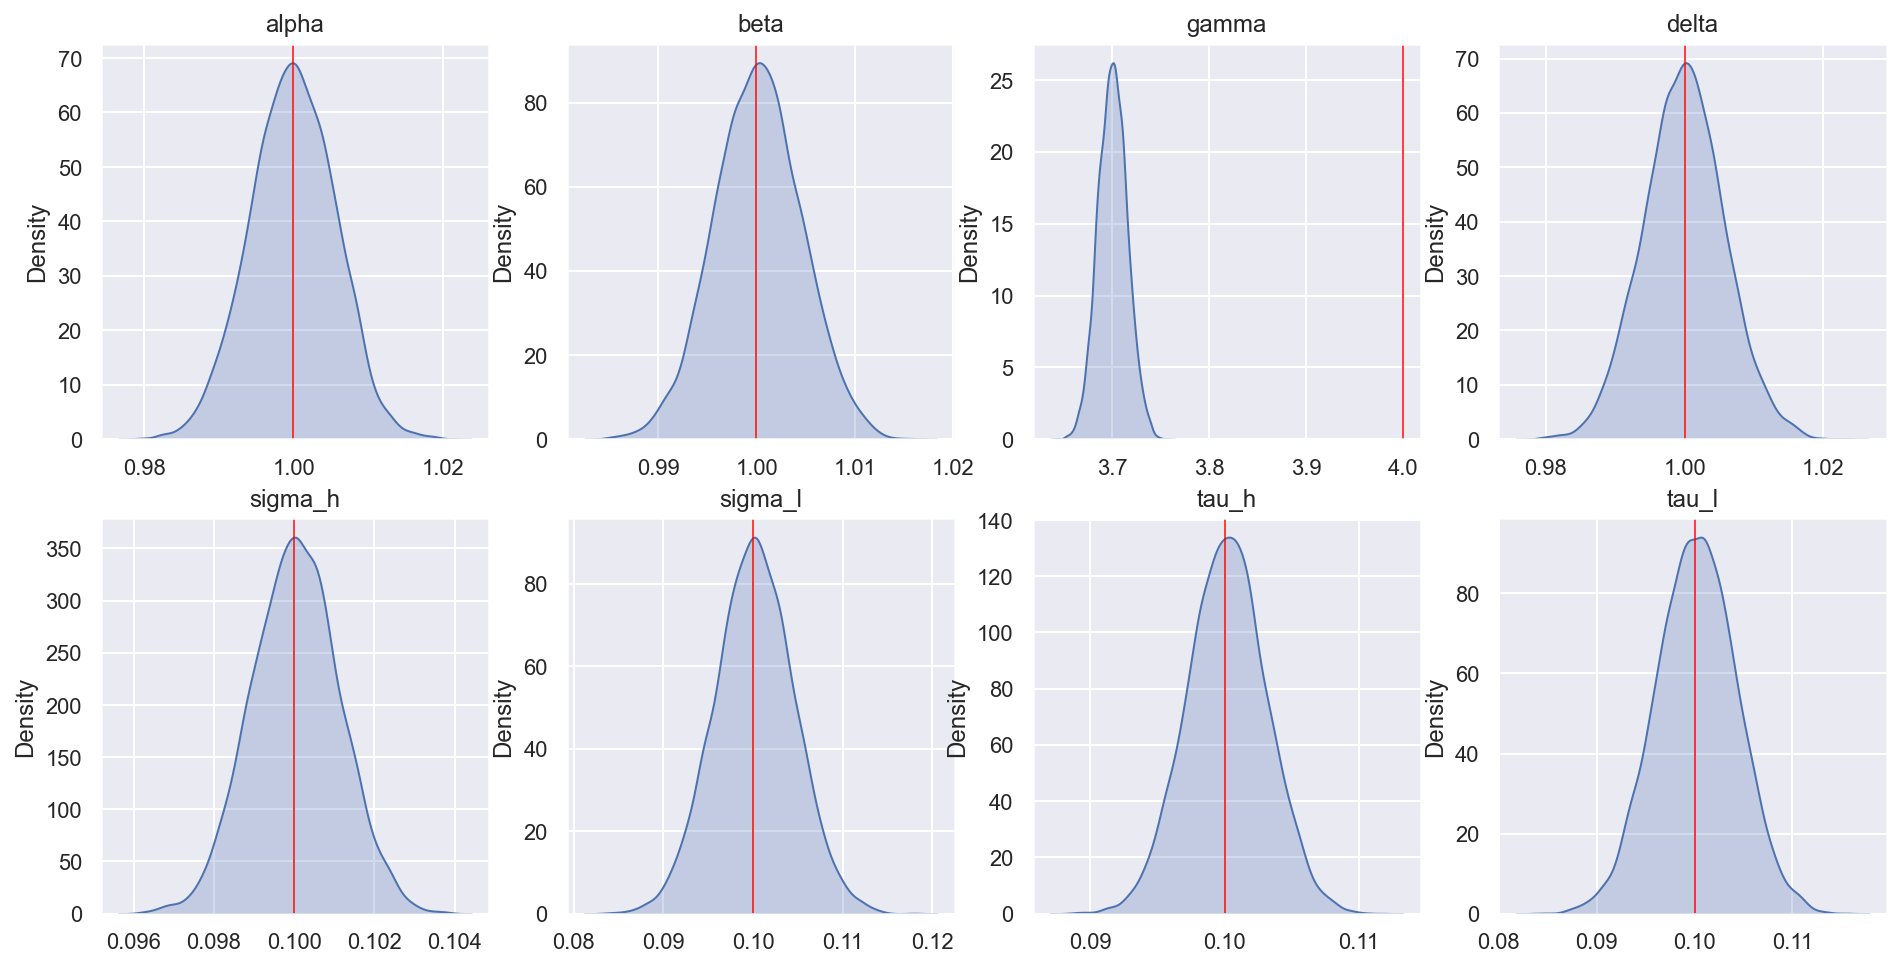

In [13]:
mvn_params, mvn_hess, mvn_var = inference(
    key = key,
    loglik = get_sum_lweights_mvn,
    y_meas = y_meas,
    lr = 1e-5,
    model = lotvol_model,
    n_iter = 25,
    hessian = True,
    init_params = jnp.array([1.,1., 3.7, 1., 0.1, 0.1, 0.1, 0.1])
)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=mvn_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 6
hess = hessian(mvn_params[:i], mvn_params[i:],
               key, 
               n_particles=5000,
               y_meas=y_meas, 
               particle_sampler = particle_resample_mvn,
               model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=mvn_params[:i], cov=var_hat, shape=(5_000, ))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

#### Bootstrap Filter

In [ ]:
bs_params, bs_hess, bs_var = inference(
    key = key,
    loglik = get_sum_lweights,
    y_meas = y_meas,
    model = lotvol_model,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2])
)

mle_samples = random.multivariate_normal(key=key, mean=bs_params, cov=bs_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 6
hess = hessian(bs_params[:i], bs_params[i:],
               key, 
               n_particles=5000,
               y_meas=y_meas, 
               model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=bs_params[:i], cov=var_hat, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

### High Noise

In [ ]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/5), theta + (theta/5))))

dt = 0.1
n_res = 2
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 

key = random.PRNGKey(0)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_hi, x_state_hi = pf.simulate(model = lotvol_model, 
                                    n_obs = n_obs, 
                                    x_init = x_init, 
                                    theta = theta, 
                                    key = subkey)
y_meas_hi_abs = jnp.abs(y_meas_hi)

#### MVN Filter

In [ ]:
mvn_params, mvn_hess, mvn_var = inference(
    key = key,
    loglik = get_sum_lweights_mvn,
    y_meas = y_meas_hi,
    model = lotvol_model,
    lr = 1e-5,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2])
)

mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=mvn_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
mvn_params

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 4
hess = hessian(mvn_params[:i], mvn_params[i:],
               key, 
               n_particles=5000, 
               y_meas=y_meas_hi, 
               particle_sampler = particle_resample_mvn,
               model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=mvn_params[:i], cov=var_hat, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();

#### Bootstrap Filter

In [ ]:
bs_params, bs_hess, bs_var = inference(
    key = key,
    loglik = get_sum_lweights,
    y_meas = y_meas_hi,
    model = lotvol_model,
    init_params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.2, 0.2])
)

mle_samples = random.multivariate_normal(key=key, mean=bs_params, cov=bs_var, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [ ]:
hessian = jax.jacfwd(jax.jacrev(masked_loglik, argnums=0), argnums=0)
i = 6
hess = hessian(bs_params[:i], bs_params[i:],
               key, 
               n_particles=5000,
               y_meas=y_meas_hi, 
               model=lotvol_model)

var_hat = jnp.linalg.inv(-hess)
print("postitive semi-def: ", jnp.all(jnp.linalg.eigvals(var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=bs_params[:i], cov=var_hat, shape=(5_000, ))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)
plt.show();